In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
#tf.config.experimental.set_visible_devices([], "GPU")

# from colabtools import adhoc_import
import importlib
from userdiffusion import ode_datasets, unet, samplers, diffusion as train
importlib.reload(ode_datasets)
importlib.reload(unet)
importlib.reload(samplers)
importlib.reload(train)

import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')
import jax.numpy as jnp
import numpy as np
import jax

2024-12-17 18:52:40.936907: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 18:52:40.958893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734461560.987773   47025 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734461560.996593   47025 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 18:52:41.024662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Taos: note on Newton. Run Jupyter with only one CUDA_VISIBLE_DEVICES, otherwise, this appears to deadlock.
dt = .5
bs = 400
ds = ode_datasets.NPendulum(N=4000+bs,n=2,dt=dt)


thetas,vs = ode_datasets.unpack(ds.Zs[bs:])
test_x = ode_datasets.unpack(ds.Zs[:bs])[0]
#thetas /=thetas.std()
#thetas = jax.random.normal(jax.random.PRNGKey(38),thetas.shape)
dataset = tf.data.Dataset.from_tensor_slices(thetas)

dataiter = dataset.shuffle(len(dataset)).batch(bs).as_numpy_iterator

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [02:28<00:00,  2.97it/s]
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/jax/_src/numpy/linalg.py:1343: FutureWarning: jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, and in the future will be treated as a batched 2D solve. Use solve(a, b[..., None])[..., 0] to avoid this warning.
  warnings.warn("jnp.linalg.solve: batched 1D solves with b.ndim > 1 are deprecated, "
I0000 00:00:1734461717.454390   47025 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6


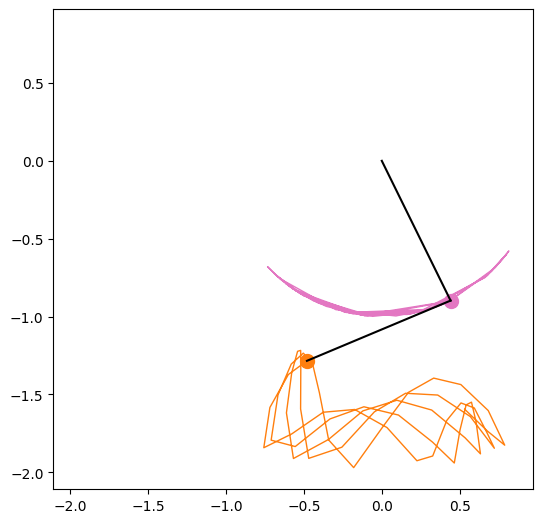

In [3]:
ds.animate()

In [4]:
x = test_x#next(dataiter())
t = np.random.rand(x.shape[0])
model = unet.UNet(unet.unet_64_config(out_dim=x.shape[-1],base_channels=24))

In [11]:
from jax import jit,vmap
@jit
def rel_err(x,y):
  return  jnp.abs(x-y).sum(-1)/(jnp.abs(x).sum(-1)+jnp.abs(y).sum(-1))


kstart=10
@jit
def log_prediction_metric(qs):
  k=kstart
  q = qs[k:]
  v = -(q[:-2]-q[2:])/(2*(ds.T[1]-ds.T[0]))
  #print(vmap(ds.mass)(q[1:-1]).shape,v.shape)
  z = ode_datasets.pack(q[1:-1],(vmap(ds.mass)(q[1:-1])@v[...,None]).squeeze(-1))
  T = ds.T_long[k+1:-1]
  z_gt = ds.integrate(z[0],T)
  return jnp.log(rel_err(z,z_gt)[1:len(T)//3]).mean()

@jit
def pmetric(qs):
  log_metric = vmap(log_prediction_metric)(qs)
  return jnp.exp(log_metric.mean()),jnp.exp(log_metric.std()/jnp.sqrt(log_metric.shape[0]))

In [6]:
noisetype='White'#@param ['White','Pink','Brown']
noise = {'White':train.Identity,'Pink':train.PinkCovariance,'Brown':train.BrownianCovariance}[noisetype]
difftype='VE'#@param ['VP','VE','SubVP','Test']
diff = {'VP':train.VariancePreserving,'VE':train.VarianceExploding,
        'SubVP':train.SubVariancePreserving,
        # 'Test':train.Test  # Taos: what is this? It is not defined in the code...
       }[difftype](noise)
epochs = 2000#@param {'type':'integer'}
score_fn = train.train_diffusion(model,dataiter,epochs,diffusion=diff,lr=3e-4)
key= jax.random.PRNGKey(38)
nll = samplers.compute_nll(diff,score_fn,key,x).mean()
# Taos: changed stochastic_sample to sde_sample
stoch_samples = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=1000,traj=False)
err = pmetric(stoch_samples)[0]
print(f"{noise.__name__} gets NLL {nll:.3f} and err {err:.3f}")

2024-12-17 18:56:47.690024: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence                                                                                            | 0/101 [00:00<?, ?it/s]
2024-12-17 18:56:55.497688: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence                                                                                  | 1/101 [00:50<1:24:08, 50.49s/it]
2024-12-17 18:56:56.706272: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence                                                                                    | 3/101 [00:51<19:15, 11.79s/it]
2024-12-17 18:56:58.396907: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence                                         

xf std {inv_sqrt_cov_xf.std()} and std_max: {std_max}


AttributeError: module 'userdiffusion.samplers' has no attribute 'stochastic_sample'

In [9]:
stoch_samples = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=1000,traj=False)

In [12]:
err = pmetric(stoch_samples)[0]
print(f"{noise.__name__} gets NLL {nll:.3f} and err {err:.3f}")

Identity gets NLL -2.252 and err 0.288


In [ ]:
# noisetype='White'#@param ['White','Pink','Brown']
# noise = {'White':train.Identity,'Pink':train.PinkCovariance,'Brown':train.BrownianCovariance}[noisetype]

# difftype='VE'#@param ['VP','VE','SubVP','Test']
# diff = {'VP':train.VariancePreserving,'VE':train.VarianceExploding,
#         'SubVP':train.SubVariancePreserving,'Test':train.Test}[difftype](noise)
# epochs = 2000#@param {'type':'integer'}

#outputs= []
# for noise in [train.WhiteCovariance]:#train.BrownianCovariance,train.PinkCovariance,train.WhiteCovariance]:
#   for multiplier in [.1,.3,1,3,10,30]:
#     noise.multiplier=multiplier
#     diff = train.VarianceExploding(noise)
#     score_fn = train.train_diffusion(model,dataiter,epochs,diffusion=diff,lr=3e-4)
#     key= jax.random.PRNGKey(38)
#     nll = samplers.compute_nll(diff,score_fn,key,x).mean()
#     stoch_samples = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=1000,traj=False)
#     err = pmetric(stoch_samples)[0]
#     outputs.append(f"{noise.__name__} with scale {multiplier} gets NLL {nll:.3f} and err {err:.3f}")
#     print(outputs[-1])

In [13]:
print(outputs)

NameError: name 'outputs' is not defined

In [ ]:
outputs2=outputs

In [ ]:
for output in outputs:
  print(output)

In [14]:
importlib.reload(samplers)
importlib.reload(train)
#samplers.probability_flow(diff,score_fn,x,1e-4,1.).std()

<module 'userdiffusion.diffusion' from '/root/workspace/GitHub/pmlr-v202-finzi23a/src/userdiffusion/diffusion.py'>

In [15]:
samples = noise.sample(jax.random.PRNGKey(39),x.shape)
samples2 = jax.random.normal(jax.random.PRNGKey(39),x.shape)
samples2 = jnp.cumsum(samples2,axis=1)
half_x = x[:,:x.shape[1]//2]
samples2 = jnp.concatenate([half_x,half_x[:,::-1]],axis=1)

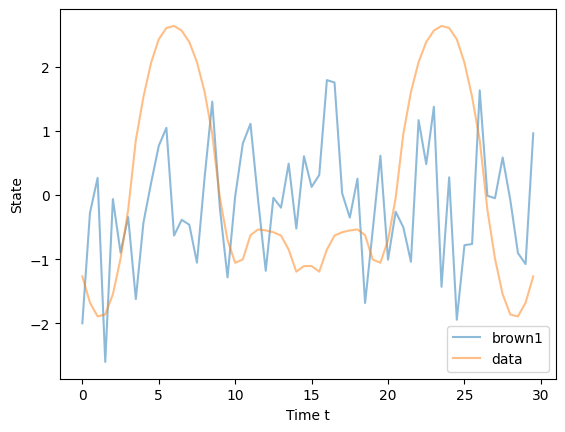

In [16]:
import matplotlib.pyplot as plt
i=1 #@param {type:"slider", min:0, max:30, step:1}
plt.plot(ds.T_long,samples[i,:,-1].T,alpha=1/2,label='brown1')
plt.plot(ds.T_long,samples2[i,:,-1].T,alpha=1/2,label='data')
plt.xlabel('Time t')
plt.ylabel(r'State')
plt.legend()

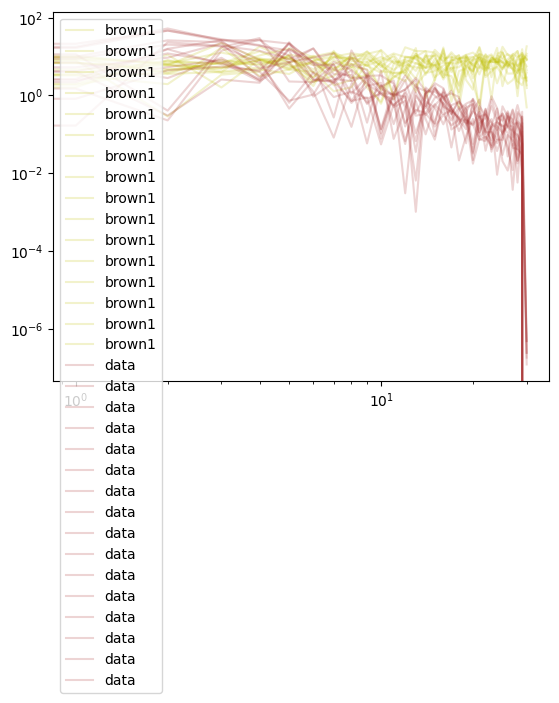

In [17]:
import matplotlib.pyplot as plt
i=5 #@param {type:"slider", min:0, max:30, step:1}
fourier_mag1 = jnp.abs(jnp.fft.rfft(samples[::25,:,-1],axis=1))
fourier_mag2 = jnp.abs(jnp.fft.rfft(samples2[::25,:,-1],axis=1))
plt.plot(fourier_mag1.T,alpha=1/5,label='brown1',color='y')
plt.plot(fourier_mag2.T,alpha=1/5,label='data',color='brown')
plt.yscale('log')
plt.xscale('log')
# plt.xlabel('Time t')
# plt.ylabel(r'State')
plt.legend()

Sample generation

In [22]:
stoch_samples = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=1000,traj=False)
sample_traj = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=1000,traj=True)
# Taos: changed samplers.sample to samplers.ode_sample
det_samples = samplers.ode_sample(diff,score_fn,key,x[:30].shape)

ODE Solve: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:15<00:00,  5.10it/s]


Text(0, 0.5, 'State')

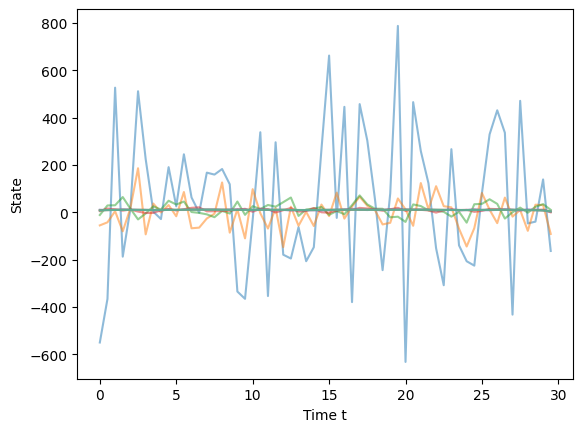

In [23]:
import matplotlib.pyplot as plt
i=6 #@param {type:"slider", min:0, max:30, step:1}
plt.plot(ds.T_long,sample_traj[0::100,i,:,-1].T,alpha=1/2)
plt.xlabel('Time t')
plt.ylabel(r'State')
#plt.ylim(-5,5)
#plt.legend([r'GT',r'Model'])

In [24]:
from jax import vmap
n=sample_traj.shape[0]+1
ts = (.5+jnp.arange(n)[::-1])[:-1]/n
scores = vmap(score_fn)(sample_traj,ts).reshape(sample_traj.shape)
best_reconstructions = (sample_traj+diff.sigma(ts)[:,None,None,None]**2*scores)/diff.scale(ts)[:,None,None,None]

/tmp/ipykernel_47025/1446354907.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
/tmp/ipykernel_47025/1446354907.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)


<Axes: ylabel='diffusion time (0,1)'>

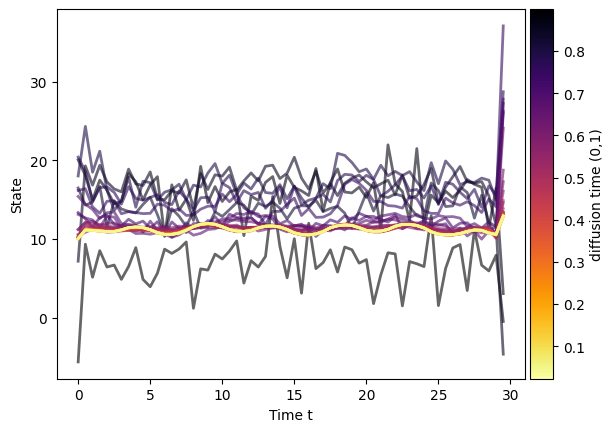

In [25]:
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

i=4 #@param {type:"slider", min:0, max:30, step:1}

cmap='inferno'


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
data = best_reconstructions[100::25,i,:,-1].T
ax1.plot(ds.T_long,data[:],alpha=.6,lw=2)
colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
#colors = [colors(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.xlabel('Time t')
plt.ylabel(r'State')
#plt.ylim(-2,2)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmin=ts[100], vmax=ts[-25])    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)
#cb1.ax.invert_yaxis()
cb1.set_label('diffusion time (0,1)')
plt.gcf().add_axes(ax_cb)

(999, 30, 60, 2)


/tmp/ipykernel_47025/1025666951.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
/tmp/ipykernel_47025/1025666951.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)


<Axes: ylabel='diffusion time (0,1)'>

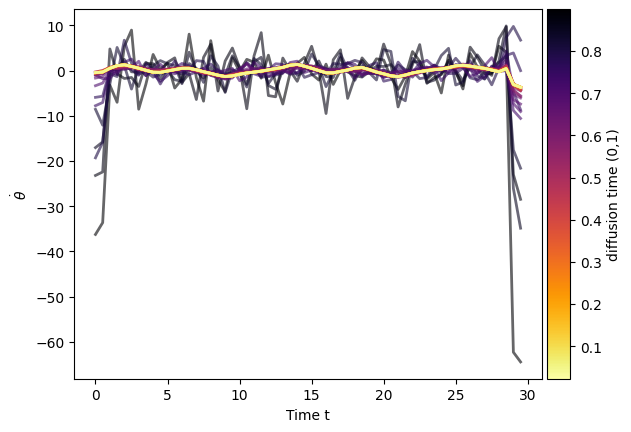

In [26]:
from scipy.ndimage import correlate1d
i=22 #@param {type:"slider", min:0, max:30, step:1}
vs = -correlate1d(best_reconstructions,np.array([-1,0,1])/2/(ds.T[1]-ds.T[0]),axis=2)
print(vs.shape)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
data = vs[100::25,i,:,-1].T
ax1.plot(ds.T_long,data[:],alpha=.6,lw=2)
colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
#colors = [colors(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.xlabel('Time t')
plt.ylabel(r'$\dot \theta$')
#plt.ylim(-2,2)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmin=ts[100], vmax=ts[-25])    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)
#cb1.ax.invert_yaxis()
cb1.set_label('diffusion time (0,1)')
plt.gcf().add_axes(ax_cb)

/tmp/ipykernel_47025/2862511934.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
/tmp/ipykernel_47025/2862511934.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)


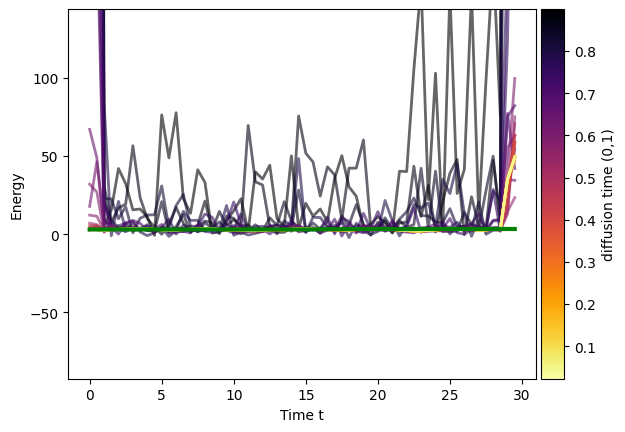

In [28]:
i=12 #@param {type:"slider", min:0, max:30, step:1}
vs = -correlate1d(best_reconstructions,np.array([-1,0,1])/2/(ds.T[1]-ds.T[0]),axis=2)
z = ode_datasets.pack(best_reconstructions,(vmap(vmap(vmap(ds.mass)))(best_reconstructions)@vs[...,None]).squeeze(-1))
Hs = vmap(vmap(vmap(ds.hamiltonian)))(z)
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
data = Hs[100::25,i,:].T
ax1.plot(ds.T_long,data[:],alpha=.6,lw=2)
colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
#colors = [colors(i) for i in np.linspace(0, 1,len(ax1.lines))]
for k,j in enumerate(ax1.lines):
    j.set_color(colors[k])
plt.xlabel('Time t')
plt.ylabel(r'Energy')
minn,maxx = data[:,-1].min(),data[:,-1].max()
plt.ylim(minn-2*(maxx-minn),maxx+2*(maxx-minn))
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmin=ts[100], vmax=ts[-25])    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)
#cb1.ax.invert_yaxis()
cb1.set_label('diffusion time (0,1)')
plt.gcf().add_axes(ax_cb)
z0 = z[-1,:,0]
z_gts = vmap(ds.integrate,(0,None),0)(z0,ds.T_long)
ax1.plot(ds.T_long,vmap(vmap(ds.hamiltonian))(z_gts)[i],color='g',lw=3)

/tmp/ipykernel_47025/2492434644.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
/tmp/ipykernel_47025/2492434644.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)


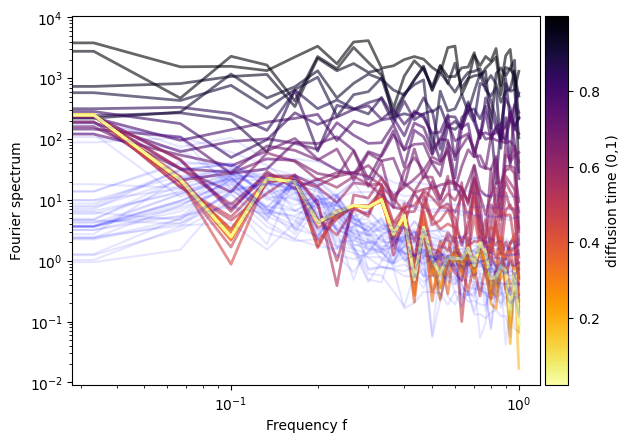

In [29]:
i=15 # @param {type:"slider", min:0, max:30, step:1}
nn = sample_traj.shape[2]
fft = jnp.abs(np.fft.rfft(sample_traj,axis=2))#[:,:,:nn//2]
freq = np.fft.rfftfreq(sample_traj.shape[2],d=(ds.T[1]-ds.T[0]))#[:nn//2]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
data = fft[0::25,i,:,-1].T
ax1.plot(freq,data[:,:],alpha=.6,lw=2)
colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
#colors = [colors(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.xlabel('Frequency f')
plt.ylabel(r'Fourier spectrum')
plt.yscale('log')
plt.xscale('log')
#plt.ylim(-2,2)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmin=ts[0], vmax=ts[-25])    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)
#cb1.ax.invert_yaxis()
cb1.set_label('diffusion time (0,1)')
plt.gcf().add_axes(ax_cb)
ax1.plot(freq,jnp.abs(np.fft.rfft(x,axis=1))[::10,:,-1].T,color='blue',alpha=.1);

/tmp/ipykernel_47025/992598995.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
/tmp/ipykernel_47025/992598995.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)


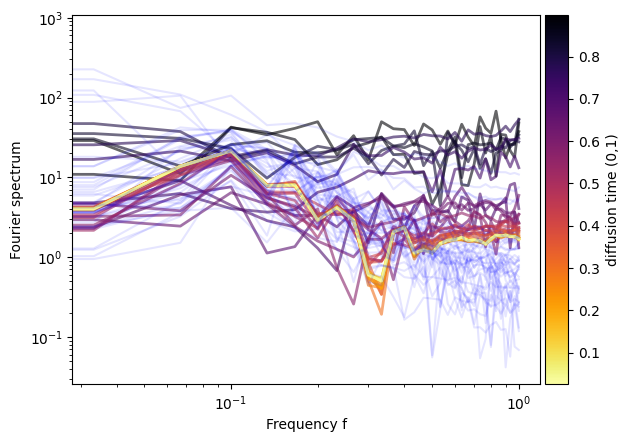

In [30]:
i=8 # @param {type:"slider", min:0, max:30, step:1}
nn = best_reconstructions.shape[2]
fft = jnp.abs(np.fft.rfft(best_reconstructions,axis=2))#[:,:,:nn//2]
freq = np.fft.rfftfreq(best_reconstructions.shape[2],d=(ds.T[1]-ds.T[0]))#[:nn//2]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
data = fft[100::25,i,:,-1].T
ax1.plot(freq,data[:,:],alpha=.6,lw=2)
colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
#colors = [colors(i) for i in np.linspace(0, 1,len(ax1.lines))]
for i,j in enumerate(ax1.lines):
    j.set_color(colors[i])
plt.xlabel('Frequency f')
plt.ylabel(r'Fourier spectrum')
plt.yscale('log')
plt.xscale('log')
#plt.ylim(-2,2)
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmax=ts[100], vmin=ts[-25])    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)
#cb1.ax.invert_yaxis()
cb1.set_label('diffusion time (0,1)')
plt.gcf().add_axes(ax_cb)
ax1.plot(freq,jnp.abs(np.fft.rfft(x,axis=1))[::10,:,-1].T,color='blue',alpha=.1);

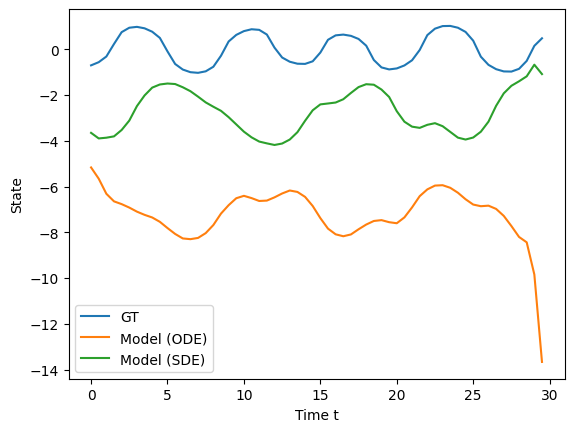

In [31]:

import matplotlib.pyplot as plt
i=20 # @param {type:"slider", min:0, max:30, step:1}
plt.plot(ds.T_long,x[i,:,-1])
plt.plot(ds.T_long,det_samples[i,:,-1])
plt.plot(ds.T_long,stoch_samples[i,:,-1])
plt.xlabel('Time t')
plt.ylabel(r'State')
plt.legend([r'GT',r'Model (ODE)', r'Model (SDE)'])

Test ability to condition model on previous timesteps

In [32]:
from jax import grad,jit
condition_amount = 13# @param {type:"slider", min:0, max:50, step:1}
mb = x[:30,:]


def inpainting_scores(diffusion,scorefn,observed_values,slc):
  b,n,c = observed_values.shape
  def conditioned_scores(xt,t):
    unflat_xt = xt.reshape(b,-1,c)

    observed_score = diffusion.noise_score(unflat_xt[:,slc],observed_values,t)
    unobserved_score = scorefn(xt,t).reshape(b,-1,c)
    combined_score = unobserved_score.at[:,slc].set(observed_score)
    return combined_score
  return conditioned_scores

def inpainting_scores2(diffusion,scorefn,observed_values,slc):
  b,n,c = observed_values.shape
  def conditioned_scores(xt,t):
    unflat_xt = xt.reshape(b,-1,c)

    observed_score = diffusion.noise_score(unflat_xt[:,slc],observed_values,t)
    unobserved_score = scorefn(xt,t).reshape(b,-1,c)
    def constraint(xt):
      one_step_xhat = (xt+diffusion.sigma(t)**2*scorefn(xt,t))/diffusion.scale(t)
      return jnp.sum((one_step_xhat.reshape(b,-1,c)[:,slc]-observed_values)**2)
    #unobserved_score -= grad(constraint)(xt).reshape(unflat_xt.shape)*10/(diff.g2(t)/2)
    unobserved_score -= grad(constraint)(xt).reshape(unflat_xt.shape)*30*diff.scale(t)**2/diff.sigma(t)**2
    combined_score = unobserved_score.at[:,slc].set(observed_score)
    return combined_score#.reshape(-1)
  return jit(conditioned_scores)

slc = slice(condition_amount)
conditioned_samples = samplers.sde_sample(diff,inpainting_scores2(diff,score_fn,mb[:,slc],slc),key,mb.shape,nsteps=1000,traj=True)


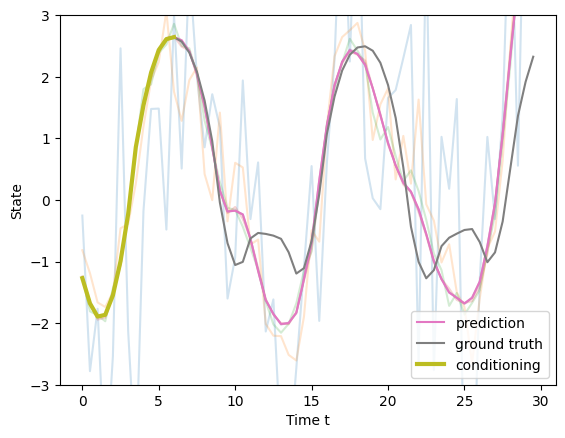

In [33]:
import matplotlib.pyplot as plt
i=1 # @param {type:"slider", min:0, max:30, step:1}
plt.plot(ds.T_long,conditioned_samples[-600::100,i,:,-1].T,zorder=0,alpha=.2)
plt.plot(ds.T_long,conditioned_samples[-1,i,  :,-1].T,zorder=2,label='prediction')
plt.plot(ds.T_long,x[i,:,-1],label='ground truth',alpha=1,zorder=99)
plt.plot(ds.T_long[slc],x[i,slc,-1],label='conditioning',alpha=1,zorder=100,lw=3)

plt.xlabel('Time t')
plt.ylabel(r'State')
plt.ylim(-3,3)
plt.legend()
#plt.legend([r'GT',r'Model'])

In [ ]:
conditioned_sample = samplers.ode_sample(diff,inpainting_scores2(diff,score_fn,mb[:,slc],slc),key,mb.shape)

ODE Solve:   3%|█████▋                                                                                                                                                                                                                    | 26/1000 [01:06<19:25,  1.20s/it]

In [ ]:
from jax import jit,vmap,random

@jit
def rel_err(z1,z2):
  return jnp.abs((jnp.abs(z1-z2)).sum(-1)/(jnp.abs(z1).sum(-1)*jnp.abs(z2).sum(-1)))

gt = x[:30]
for pred in [conditioned_samples[-1],conditioned_sample]:
  clamped_errs = jax.lax.clamp(1e-5,rel_err(pred,gt),np.inf)
  rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
  rel_stds = np.exp(jnp.log(clamped_errs).std(0))
  plt.plot(ds.T_long,rel_errs)
  plt.fill_between(ds.T_long, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend(['SDE completion','ODE completion'])

In [ ]:
i=23 # @param {type:"slider", min:0, max:29, step:1}
plt.plot(ds.T_long,x[i,:,-1])
plt.plot(ds.T_long[slc],x[i,slc,-1],lw=3)
plt.plot(ds.T_long,conditioned_sample[i,:,-1])
plt.xlabel('Time t')
plt.ylabel(r'State')
plt.legend([r'GT','Conditioning',r'Model'])
plt.ylim(-3,3)

Energy Conditioning

In [ ]:
from jax import grad,jit
mb = x[:30,:]
b,_,c = mb.shape
data_std = thetas.std()
def energy_conditioned_scores(diffusion,scorefn):
  def conditioned_scores(xt,t):
    unflat_xt = xt.reshape(b,-1,c)


    unobserved_score = scorefn(xt,t).reshape(b,-1,c)
    def constraint(xt):
      q = (xt+diffusion.sigma(t)**2*scorefn(xt,t))/diffusion.scale(t)
      q = q.reshape(b,-1,c)
      #v = -correlate1d(one_step_xhat,np.array([-1,0,1])/2/(ds.T[1]-ds.T[0]),axis=1)
      v = -(q[:,:-2]-q[:,2:])/(2*(ds.T[1]-ds.T[0]))
      z = ode_datasets.pack(q[:,1:-1],(vmap(vmap(ds.mass))(q[:,1:-1])@v[...,None]).squeeze(-1))
      Hs = vmap(vmap(ds.hamiltonian))(z)
      return jnp.sum(jnp.square(Hs-Hs.mean(axis=1,keepdims=True)))
    #unobserved_score -= grad(constraint)(xt).reshape(unflat_xt.shape)*10/(diff.g2(t)/2)
    unobserved_score -= grad(constraint)(xt).reshape(unflat_xt.shape)*(diff.scale(t)**2/diff.sigma(t)**2)*.5/(1+diff.sigma(t)**2/data_std**2)
    return unobserved_score
  return jit(conditioned_scores)




In [ ]:
from jax import vmap,grad,jit
from scipy.ndimage import correlate1d

energy_samples_traj = samplers.sde_sample(diff,energy_conditioned_scores(diff,score_fn),key,mb.shape,nsteps=1000,traj=True)
n=energy_samples_traj.shape[0]+1
ts = (.5+jnp.arange(n)[::-1])[:-1]/n
scores = vmap(score_fn)(energy_samples_traj,ts).reshape(energy_samples_traj.shape)
best_reconstructions = (energy_samples_traj+diff.sigma(ts)[:,None,None,None]**2*scores)/diff.scale(ts)[:,None,None,None]
vs = -correlate1d(best_reconstructions,np.array([-1,0,1])/2/(ds.T[1]-ds.T[0]),axis=2)
z = ode_datasets.pack(best_reconstructions,(vmap(vmap(vmap(ds.mass)))(best_reconstructions)@vs[...,None]).squeeze(-1))
Hs = vmap(vmap(vmap(ds.hamiltonian)))(z)
kstart=10
z0 = z[-1,:,kstart]
#print(vmap(ds.hamiltonian)(z0)[i])
z_gts = vmap(ds.integrate,(0,None),0)(z0,ds.T_long[kstart:])

In [ ]:
import matplotlib.pyplot as plt

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

i=14 #@param {type:"slider", min:0, max:30, step:1}

cmap='inferno'

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
data = Hs[100::25,i,:].T
#print(data[:,-1])
ax1.plot(ds.T_long,data[::-1],alpha=.6,lw=2)
colors=list(mpl.cm.get_cmap(cmap)(np.linspace(0,1,len(ax1.lines))))
#colors = [colors(i) for i in np.linspace(0, 1,len(ax1.lines))]
for k,j in enumerate(ax1.lines):
    j.set_color(colors[k])
plt.xlabel('Time t')
plt.ylabel(r'Energy')
minn,maxx = data[:,-1].min(),data[:,-1].max()
plt.ylim(minn-2*(maxx-minn),maxx+2*(maxx-minn))
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
norm = mpl.colors.Normalize(vmin=ts[100], vmax=ts[-25])    
cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=mpl.cm.get_cmap(f'{cmap}_r'), orientation='vertical',norm=norm)
#cb1.ax.invert_yaxis()
cb1.set_label('diffusion time (0,1)')
plt.gcf().add_axes(ax_cb)

ax1.plot(ds.T_long[kstart:],vmap(vmap(ds.hamiltonian))(z_gts)[i],color='g',lw=3)

In [ ]:
from jax import jit,vmap
@jit
def rel_err(x,y):
  return  jnp.abs(x-y).sum(-1)/(jnp.abs(x).sum(-1)+jnp.abs(y).sum(-1))


kstart=10
@jit
def log_prediction_metric(qs):
  k=kstart
  q = qs[k:]
  v = -(q[:-2]-q[2:])/(2*(ds.T[1]-ds.T[0]))
  #print(vmap(ds.mass)(q[1:-1]).shape,v.shape)
  z = ode_datasets.pack(q[1:-1],(vmap(ds.mass)(q[1:-1])@v[...,None]).squeeze(-1))
  T = ds.T_long[k+1:-1]
  z_gt = ds.integrate(z[0],T)
  return jnp.log(rel_err(z,z_gt)[1:len(T)//3]).mean()

@jit
def pmetric(qs):
  log_metric = vmap(log_prediction_metric)(qs)
  return jnp.exp(log_metric.mean()),jnp.exp(log_metric.std()/jnp.sqrt(log_metric.shape[0]))

In [ ]:
energy_samples_stoch = samplers.sde_sample(diff,energy_conditioned_scores(diff,score_fn),key,mb.shape,nsteps=2000,traj=False)
print(f'SDE performance {pmetric(energy_samples_stoch)[0]}')

In [ ]:
energy_samples_det = samplers.ode_sample(diff,energy_conditioned_scores(diff,score_fn),key,mb.shape)
print(f'ODE performance {pmetric(energy_samples_det)[0]}')

Unconditional Prediction quality

In [ ]:
stoch_samples = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=1000,traj=False)
det_samples = samplers.ode_sample(diff,score_fn,key,x[:30].shape)
print(f'ODE performance {pmetric(det_samples)[0]}')
print(f'SDE performance {pmetric(stoch_samples)[0]}')

In [ ]:
from jax import random
key = random.PRNGKey(45)
#s=s2#,history = samplers.sde_sampler(denoiser,params,key,(32,)+data.shape[1:],nsteps=500,smin=sigma_min,smax=sigma_max)
s = stoch_samples#energy_samples_det#stoch_samples

k = 5
q = s[:,k:]
v = -(q[:,:-2]-q[:,2:])/(2*(ds.T[1]-ds.T[0]))
z = ode_datasets.pack(q[:,1:-1],(vmap(vmap(ds.mass))(q[:,1:-1])@v[...,None]).squeeze(-1))
T = ds.T_long[k+1:-1]
z0 = z[:,0]
z_gts = vmap(ds.integrate,(0,None),0)(z0,T)
z_pert = vmap(ds.integrate,(0,None),0)(z0+1e-3*np.random.randn(*z0.shape),T)
z_random = vmap(ds.integrate,(0,None),0)(ds.sample_initial_conditions(z0.shape[0]),T)


In [ ]:
for pred in [z,z_pert,z_random]:
  clamped_errs = jax.lax.clamp(1e-3,rel_err(pred,z_gts),np.inf)
  rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
  rel_stds = np.exp(jnp.log(clamped_errs).std(0))
  plt.plot(T,rel_errs)
  plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Prediction Error')
plt.legend(['Diffusion Model Rollout','1e-3 Perturbed GT','Random Init'])

In [ ]:
H_gts = vmap(vmap(ds.hamiltonian))(z_gts)
for pred in [z,z_pert,z_random]:
  Hs = vmap(vmap(ds.hamiltonian))(pred)
  clamped_errs = jax.lax.clamp(1e-3,jnp.abs(Hs-H_gts)/jnp.abs(Hs*H_gts),np.inf)
  rel_errs = np.exp(jnp.log(clamped_errs).mean(0))
  rel_stds = np.exp(jnp.log(clamped_errs).std(0))
  plt.plot(T,rel_errs)
  plt.fill_between(T, rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1)

plt.plot()
plt.yscale('log')
plt.xlabel('Time')
plt.ylabel('Energy Error')
plt.legend(['Diffusion Model Rollout','1e-3 Perturbed GT','Random Init'])

Compared trajectories

In [ ]:
for i in range(10):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  line1, = ax.plot(T,z_gts[i,:,0])
  line2, = ax.plot(T,z[i,:,0])
  line3, = ax.plot(T,z_pert[i,:,0])
  plt.xlabel('Time t')
  plt.ylabel(r'State')
  plt.legend(['gt','model','pert'])

In [ ]:
for i in range(10):
  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)
  line1, = ax.plot(T,z_gts[i,:,0])
  line2, = ax.plot(T,z[i,:,0])
  line3, = ax.plot(T,z_gts[i,:,-1])
  line5, = ax.plot(T,z[i,:,-1])
  plt.xlabel('Time t')
  plt.ylabel(r'State')
  plt.legend([r'$\theta_0$ gt',r'$\theta_0$ model',r'v gt', r'v model'])

In [ ]:
ds.animate()

In [ ]:
metric_vals =[]
metric_stds = []
Ns = [25,50,100,200,500,1000,2000]
for N in Ns:
  s = samplers.sde_sample(diff,score_fn,key,x[:30].shape,nsteps=N)
  mean,std = pmetric(s)
  metric_vals.append(mean)
  metric_stds.append(std)
metric_vals = np.array(metric_vals)
metric_stds = np.array(metric_stds)

plt.plot(Ns,metric_vals)
plt.fill_between(Ns, metric_vals/metric_stds, metric_vals*metric_stds,alpha=.3)
plt.xlabel('Sampler steps')
plt.ylabel('Pmetric value')
plt.xscale('log')

In [ ]:
ds2 = ode_datasets.NPendulum(N=50,n=2,dt=.002)
thetas2,vs2 = ode_datasets.unpack(ds2.Zs)
test_x2 = thetas2
#test_x2 = -correlate1d(test_x2,np.array([-1,0,1])/2/(ds.T[1]-ds.T[0]),axis=1)
freq = np.fft.rfftfreq(test_x2.shape[1],d=(ds2.T[1]-ds2.T[0]))
ffts  =jnp.abs(np.fft.rfft(test_x2,axis=1))
avg_freq  =jnp.exp(jnp.log(ffts)[:,:,-1]).mean(0)
plt.plot(freq,avg_freq.T,color='blue',label=r'2 Pendulum $\theta$');
plt.plot(freq,100/freq,label=r'1/f')
plt.plot(freq,30/freq**2,label=r'1/$f^2$')
plt.plot(freq,10/freq**3,label=r'1/$f^3$')
#plt.plot(freq,np.exp(-10*freq**2),label=r'$e^{-f^2}$')
plt.plot(freq,ffts[:,:,-1].T,color='y',alpha=.2);
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-3,1e5)
plt.xlabel('Frequency f')
plt.ylabel(r'Fourier spectrum')
plt.legend()

In [ ]:
z = noise.sample(jax.random.PRNGKey(38),x.shape)
freq = np.fft.rfftfreq(z.shape[1],d=(ds.T[1]-ds.T[0]))
ffts  =jnp.abs(np.fft.rfft(z,axis=1))
avg_freq  =jnp.exp(jnp.log(ffts)[:,:,-1]).mean(0)
plt.plot(freq,avg_freq.T,color='blue',label=r'2 Pendulum $\theta$');
plt.plot(freq,100/freq,label=r'1/f')
plt.plot(freq,30/freq**2,label=r'1/$f^2$')
plt.plot(freq,10/freq**3,label=r'1/$f^3$')
#plt.plot(freq,np.exp(-10*freq**2),label=r'$e^{-f^2}$')
plt.plot(freq,ffts[:,:,-1].T,color='y',alpha=.2);
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-3,1e5)
plt.xlabel('Frequency f')
plt.ylabel(r'Fourier spectrum')
plt.legend()